In [1]:
import tensorflow as tf
import numpy as np
import pandas as pb
import math
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
import time
from scipy import sparse
import os
from scipy.stats import linregress
import copy
from scipy.stats import pearsonr,spearmanr
from sklearn.model_selection import train_test_split
def banland_sample(feature,target,proportion):#For up-sampling
    feature=list(np.array(feature))
    target=list(np.array(target))
    resist,non_resist=[],[]
    for i in zip(feature,target):
        if i[1][0]==0:#non-resistance genotype
            non_resist.append(i[0])
        elif i[1][0]==1:#resistance genotype
            resist.append(i[0])
    l_non_resist,l_resist=len(non_resist),len(resist)
    new_x,new_y=[],[]
    id_resist= np.random.choice(l_resist,int((l_non_resist-l_resist)*proportion))#upsampling
    new_x.extend(non_resist)
    new_y.extend([[0]]*l_non_resist)
    if len(new_x)==len(new_y):
        new_x.extend(resist)
        new_y.extend([[1]]*l_resist)
        resist=np.array(resist)
        up_resist=resist[id_resist]
        new_x.extend(up_resist)
        new_y.extend([[1]]*len(id_resist))
        new_x=np.array(new_x)
        new_y=np.array(new_y)
    else:    
        print("error,make double check of input")
    return new_x,new_y

Epoch 1/40
146/146 [==============================] - ETA: 0s - loss: 0.0390 - mse: 0.0390
Epoch 00001: val_loss improved from inf to 0.03727, saving model to ./AUC_binary_classification_20200107/regression_9-25_caz_0.5mic_nomaxpool_drop_0.2-0.4_units32_alpha_0.2_maxpool_3-3_kernelsize21_dense40_one_layer_128batch_best.hdf5
146/146 [==============================] - 30s 204ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 2/40
146/146 [==============================] - ETA: 0s - loss: 0.0368 - mse: 0.0368
Epoch 00002: val_loss improved from 0.03727 to 0.03632, saving model to ./AUC_binary_classification_20200107/regression_9-25_caz_0.5mic_nomaxpool_drop_0.2-0.4_units32_alpha_0.2_maxpool_3-3_kernelsize21_dense40_one_layer_128batch_best.hdf5
146/146 [==============================] - 29s 195ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 3/40
146/146 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0361
Epoch

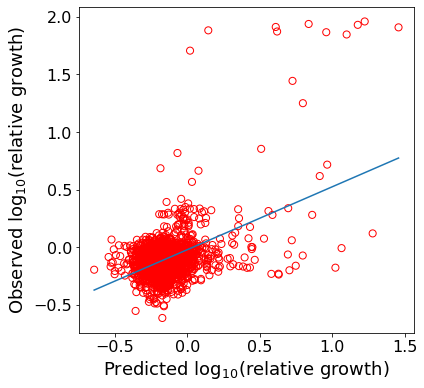

In [21]:
with open("./new_data_9-15/new_caz_0.5mic_9-15_regression_no_balance_mutiple_.csv","r") as input1:
    x_list,y_list=[],[]
    for line in input1:
        if "po" not in line:
            line_list=line.strip().split()      
            fea=np.array(line_list[:-1]).reshape((-1,4))
            x_list.append(fea)
            y_list.append(line_list[-1])

x_array=np.array(x_list).astype(np.float32)
y_array=np.array(y_list).astype(np.float32).reshape((-1,1))
#split trainning set and test set
xx_train, xx_test, yy_train, yy_test = train_test_split(x_array, y_array, test_size=2300,random_state=0)  
x = tf.convert_to_tensor(xx_train)
y = tf.convert_to_tensor(yy_train, dtype=tf.float32)
idx = tf.range(xx_train.shape[0])
idx = tf.random.shuffle(idx)

x_train, y_train = tf.gather(x, idx[:int(0.9 * len(idx))]), tf.gather(y, idx[:int(0.9 * len(idx))])#trainning set
x_val, y_val = tf.gather(x, idx[int(0.9 * len(idx)):]), tf.gather(y, idx[int(0.9 * len(idx)):])#validation set
x_test = tf.convert_to_tensor(xx_test)
y_test = tf.convert_to_tensor(yy_test,dtype=tf.float32)#test set

ban_x_train,ban_y_train=banland_sample(x_train,y_train,0.8)#upsampling
batchsz =128
db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
db = db.shuffle(7000).batch(batchsz).repeat()
db_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
db_val = db_val.batch(batchsz)
db_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
db_test = db_test.batch(batchsz)
n_units=32
##construct BLSTM
forward_lstm = layers.LSTM(n_units, return_sequences=True) 
backward_lstm = layers.LSTM(n_units,go_backwards=True,return_sequences=True)
Bid_lstm = layers.Bidirectional(forward_lstm,merge_mode='concat',backward_layer=backward_lstm)

slope=0.2
###construct model
network = Sequential([layers.Conv1D(n_units,strides=1, kernel_size=21, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=slope)), #1D convolution
                      layers.MaxPooling1D(3, 3), #1D Max polling
                      layers.Dropout(0.2),
                      Bid_lstm, # BLSTM
                      layers.Flatten(),
                      layers.Dense(40, activation=tf.keras.layers.LeakyReLU(alpha=slope)), 
                      layers.Dropout(0.4),
                      layers.Dense(1, activation='linear')])
network.build(input_shape=(None,792, 4))
network.compile(optimizer=optimizers.Adam(lr=0.001),loss="mse",metrics=['mse'])

callbacc = [tf.keras.callbacks.ModelCheckpoint(filepath="./AUC_binary_classification_20200107/regression_9-25_caz_0.5mic_nomaxpool_drop_0.2-0.4_units32_alpha_0.2_maxpool_3-3_kernelsize21_dense40_one_layer_128batch_best.hdf5", verbose=1,monitor='val_loss', save_best_only=True),
      tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_mse')
    ]
#####start training
with tf.device('/gpu:0'):
    network.fit(db, epochs=40, validation_data=db_val,shuffle=True,
                callbacks=callbacc, steps_per_epoch=x_train.shape[0]//batchsz)

network_test = Sequential([layers.Conv1D(n_units,strides=1, kernel_size=21, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=xielv)), #1D卷积
                      layers.MaxPooling1D(3, 3),
                      layers.Dropout(0.2),
                      Bid_lstm, 
                      layers.Flatten(),
                      layers.Dense(40, activation=tf.keras.layers.LeakyReLU(alpha=xielv)), 
                      layers.Dropout(0.4),
                      layers.Dense(1,activation='linear')])
network_test.build(input_shape=(None,792, 4))
network_test.compile(optimizer=optimizers.Adam(lr=0.001),loss="mse",metrics=['mse'])
network_test.load_weights("./AUC_binary_classification_20200107/regression_9-25_caz_0.5mic_nomaxpool_drop_0.2-0.4_units32_alpha_0.2_maxpool_3-3_kernelsize21_dense40_one_layer_128batch_best.hdf5")
pre=list(network_test.predict(x_test))
pre_x=[i[0] for i in pre]
dd=list(np.array(y_test))
pre_y=[i[0] for i in dd]
print(pearsonr(pre_x,pre_y))
print(spearmanr(pre_x,pre_y))
p_line = np.polyfit(pre_x, pre_y, deg=1)
p1 = np.poly1d(p_line)
p_x = [min(pre_x),max(pre_x)]
p_y= [(p_line[1] + p_line[0]* i) for i in p_x]
print(p_line,p_x,p_y)
plt.figure(figsize=(6, 6))
plt.scatter(pre_x,pre_y,s=50, facecolors='none',edgecolors='r')
xxx=[-0.7,2.5]
yyy=[-0.7,2.5]
plt.plot(p_x,p_y, '-')
plt.ylabel("Observed log$_{10}$(relative growth)",fontsize=18,family="Sans")
plt.xlabel("Predicted log$_{10}$(relative growth)",fontsize=18,family="Sans")
plt.tick_params(labelsize=16)
plt.savefig('figureS5_A_10-3.pdf', bbox_inches='tight',dpi=300) 